# General settings and loading of files

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm

%matplotlib inline

pd.options.display.max_columns = 40  # Affy csv has 30 fields
pd.options.display.mpl_style = 'default'

mpl.rc('figure', figsize=(13, 7))
mpl.rc('axes', titlesize=17, labelsize=14)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('font', family='serif')
mpl.rc('legend', fontsize=15)

In [2]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

In [3]:
GALANTER_CSV = '~/tesina/galanter_SNPs.csv'

LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!

# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

CHR_LENGTHS = '~/tesina/chr_len.csv'

In [4]:
%run discriminate_present_vs_missing.py

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [5]:
print("{} Galanter AIMs".format(len(galanter)))
print("{} present in LAT".format(len(present)))
print("{} missing in LAT".format(len(missing)))

446 Galanter AIMs
180 present in LAT
266 missing in LAT


In [6]:
%run chromosome_lenghts.py

chr_lengths = read_chr_lengths(CHR_LENGTHS)
max_len = chr_lengths.total_length.max()

### Distancias entre los AIMs por cromosoma

In [7]:
chr_lengths.loc[3]

total_length    198295559
Name: 3, dtype: int64

In [8]:
galanter[galanter.chr == 3][galanter.position > chr_lengths.loc[3].total_length]

/usr/local/lib/python3.4/dist-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs13327370,3,199228595,G,A,0.011,0.23,0.922,AFR,0.606,0.365


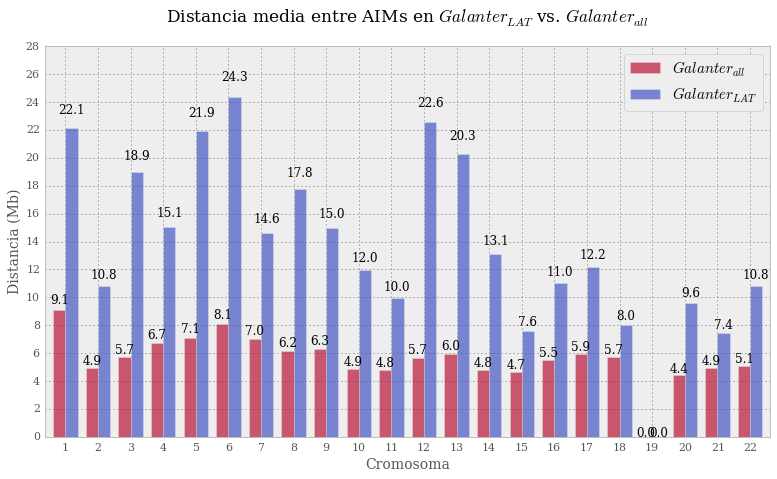

In [9]:
% run data_munging/distances_between_AIMs.py
% run SNP_distances_plots.py

galanter_vs_present_mean_distance_plot(galanter, present)
plt.show()

#### Discusión

* Las distancias medias son mucho mayores en $Galanter_{LAT}$ que en $Galanter_{all}$. En casos extremos, llega a más de 20 Mpb promedio entre AIMs, cuando esas distancias promedio no superan los 8 Mpb en el panel original.

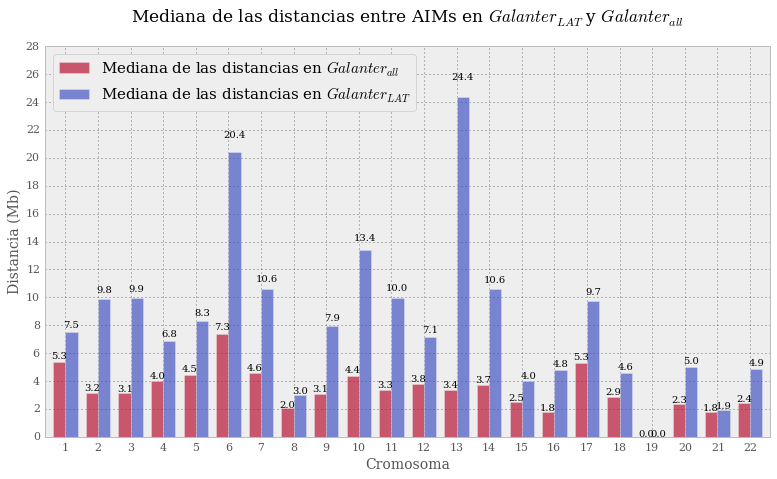

In [10]:
% run data_munging/distances_between_AIMs.py
% run SNP_distances_plots.py

galanter_vs_present_median_distance_plot(galanter, present)
plt.show()

### Discusión

__Nota__: hay un solo AIM en Galanter para el cromosoma 19, de modo que no se grafican distancias.

* En algunos casos extremos, hay hasta 1.4 Mpb (cromosoma 1) y 1 Mpb (cromosoma 8) de distancia entre dos AIMs contiguos.

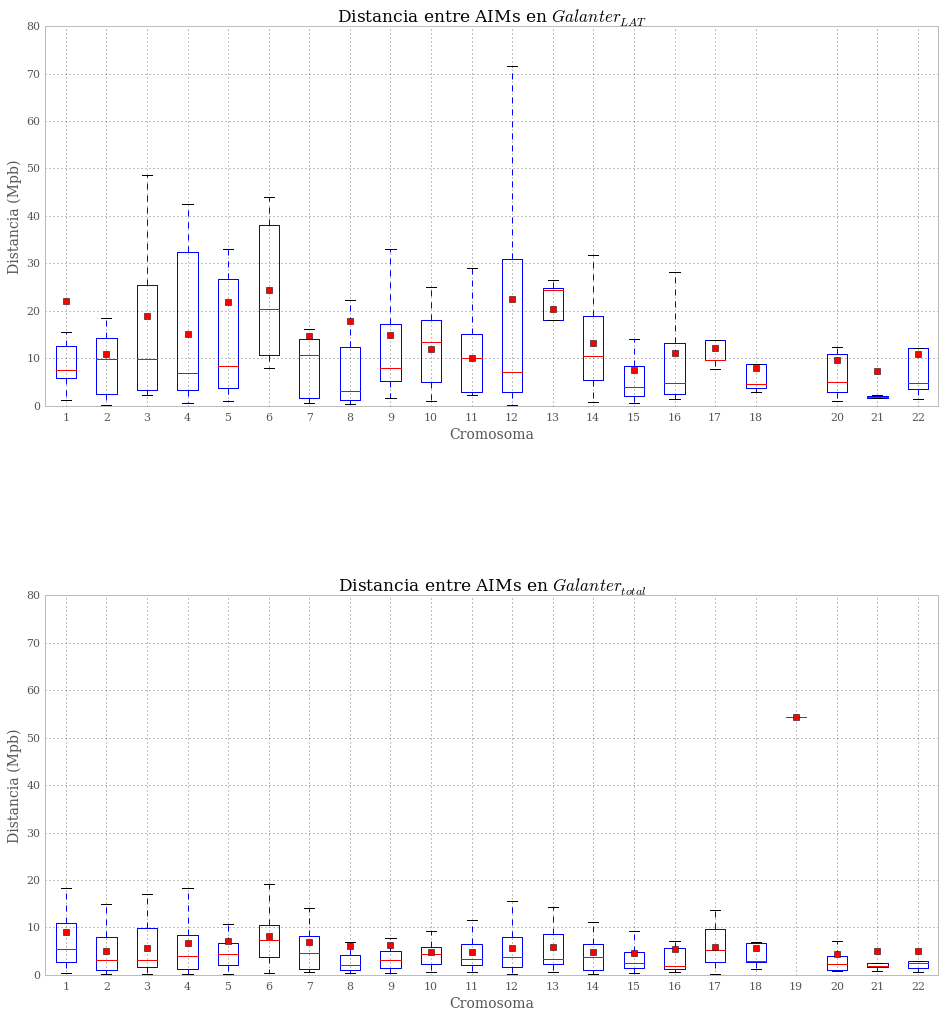

In [11]:
% run data_munging/distances_between_AIMs.py
% run SNP_distances_plots.py

ax1 = plt.subplot(211)
ax1 = distances_boxplot(present, ax=ax1, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{LAT}$")

ax2 = plt.subplot(212, sharey=ax1)
ax2 = distances_boxplot(galanter, ax=ax2, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{total}$")

f = ax2.figure
f.set_figheight(17)
f.set_figwidth(16)

plt.show()

**NOTA**: Con los outliers (`showfliers=True`) la diferencia se agranda aún más.

In [12]:
% run data_munging/distances_between_AIMs.py
% run t_test_for_snp_distances.py

df = snp_distances(galanter, present)
t_test_for_snp_distances(df['mean_distance_galanter'],
                         df['mean_distance_present'])

'mean_distance_galanter' vs. 'mean_distance_present': 
 t-crítico = -7.203729451346644 
 p-value = 9.774954843801444e-09



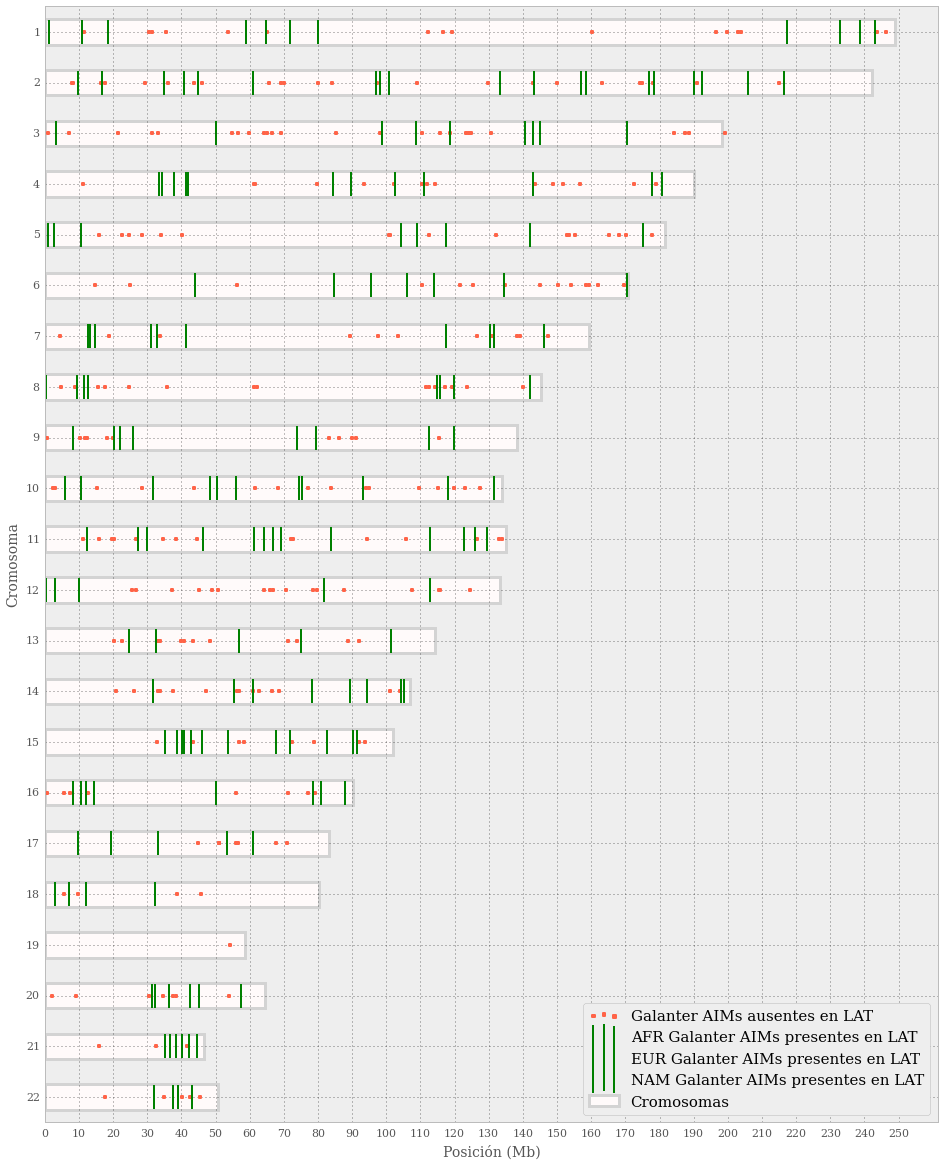

In [13]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
    ('Galanter AIMs ausentes en LAT',
     {'df': missing, 'marker': 's', 's': 7, 'color': 'tomato'}),
        
    ('AFR Galanter AIMs presentes en LAT',
     {'df': present[present.population == "AFR"], 'color': 'g'}),
        
    ('EUR Galanter AIMs presentes en LAT',
     {'df': present[present.population == "EUR"], 'color': 'g'}),
        
    ('NAM Galanter AIMs presentes en LAT',
     {'df': present[present.population == "NAM"], 'color': 'g'}),
])

chromosomes_with_SNPs_plot(chr_lengths, plot_data)
plt.show()

**TODO**: Visualize with special software, tipo http://visualization.ritchielab.psu.edu/phenograms/examples

## Diferenciar por población de referencia, present vs galanter

     $Galanter_{LAT-1}$  $Galanter_{total}$
AFR            0.344444            0.257848
EUR            0.394444            0.452915
NAM            0.261111            0.289238
     $Galanter_{Ausentes}$  $Galanter_{LAT-1}$
AFR                     62                  53
EUR                     71                 131
NAM                     47                  82


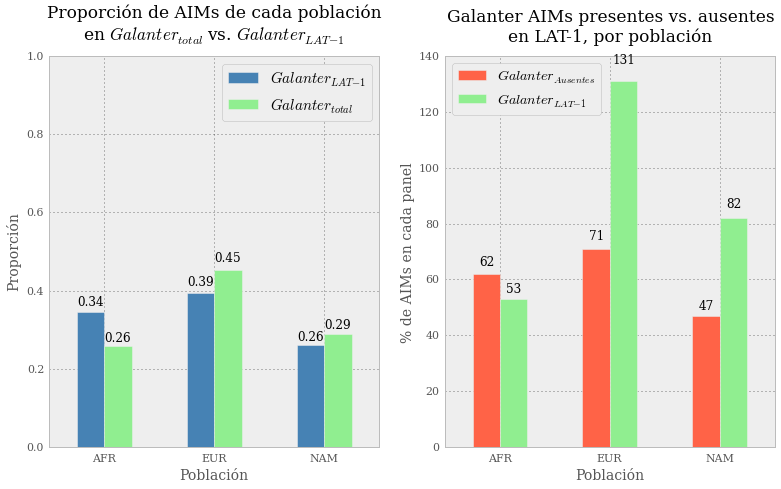

In [14]:
% run superpopulation_ratios_plot.py

superpopulation_ratios_plot(galanter, present)
superpopulation_count_plot(present, missing)

plt.show()

### Discusión

* Los AIMs de Galaner presentes en LAT-1 tienen proporciones poblacionales diferentes a las proporciones del total del panel. En $Galanter_{LAT-1}$
    - la proporción de AFR es .08 mayor
    - la proporción de EUR es .06 menor
    - la proporción de NAM es .03 menor
* Problema: El hecho de que nos quedemos con más AFR en proporción y menos EUR afectará la predición?

# Datos de 1000 genomas

In [15]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [16]:
% run extract_SNPs_from_vcf_chromosomes.py

commands = extract_SNPs_from_vcf(galanter.index.values)

# One time only run, to extract the SNPs out of the big chromosome files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

Ejemplo de la data de subpoblaciones que busco, para rs2585897:

http://browser.1000genomes.org/Homo_sapiens/Variation/Population?db=core;r=13:21398479-21399479;v=rs2585897;vdb=variation;vf=2188197

In [41]:
%run read_1000genomes_data.py
%run read_samples_data.py

from glob import glob

# samples file
samples_file = "/home/juan/tesina/1000genomes/integrated_call_samples_v3.20130502.ALL.panel"
samples = read_samples_data(samples_file)


# df_1000genomes
vcf_filenames = glob("/home/juan/tesina/1000genomes/chr_22*recode*")  # remove the '22'
dumpfile = "dumpfiles/galanter_at_1000genomes.csv"

if os.path.isfile(dumpfile):
    df_1000genomes = pd.read_csv(dumpfile, index_col='ID')
else:
    df_1000genomes = create_1000genomes_df_from_vcf(vcf_filenames)
    df_1000genomes.to_csv(dumpfile)

# frequencies_1000g
dumpfile = "dumpfiles/galanter_snps_frequencies_in_1000genomes.csv"

if os.path.isfile(dumpfile):
    frequencies_1000g = pd.read_csv(dumpfile, index_col='ID')
else:
    frequencies_1000g = create_1000genomes_frequencies_df(df_1000genomes, samples)
    frequencies_1000g.to_csv(dumpfile)

# Comparar los dos dataframes: Galanter y 1000Genomes

### Comparar SNPs

In [ ]:
print(len(df_1000genomes))
print(len(galanter))

TODO: Quién falta?

### Chequear AF

### Ver qué subpoblaciones se van en $Galanter_{missing}$ y cuáles quedan

In [ ]:
dumpfile = "population_names.csv"

if os.path.isfile(dumpfile):
    population_names = pd.read_csv(dumpfile, index_col='Population Code')
else:
    url = "http://www.1000genomes.org/category/frequently-asked-questions/population"
    df = pd.read_html(url)[0]  # First table in the page
    df.columns = df.iloc[0]
    df = df.iloc[1:, :3].set_index('Population Code')
    df.to_csv(dumpfile)
    population_names = df

population_names.head(1)

In [ ]:
def whois(pop_code):
    return population_names.loc[pop_code]['Population Description']

In [ ]:
whois('ACB')

In [ ]:
def plot_mean_freqs(df, title=""):
    df = df.join(frequencies_1000g).iloc[:, 4:].drop(['LSBL(Fst)', 'LSBL(In)'], axis=1)
    ax = df.mean().plot(kind='bar', color='cornflowerblue', figsize=(18,6), width=0.75)
    for bar in ax.patches[:3]:
        bar.set_color('coral')
    for bar in ax.patches[-6:]:
        bar.set_color('coral')
    ax.set_ylim(0,1)
    ax.set_title(title)
    ax.axhline(0.5, color='k', linestyle='--')
    annotate_bars(ax, decimals=2, fontsize=10)
    plt.show()

In [ ]:
plot_mean_freqs(missing, 'Promedio de frecuencias alélicas en $Galanter_{OUT}$, por población')

In [ ]:
plot_mean_freqs(galanter, 'Promedio de frecuencias alélicas en $Galanter_{total}$, por población')

In [ ]:
plot_mean_freqs(present, 'Promedio de frecuencias alélicas en $Galanter_{LAT-1}$, por población')

#### t test para comparar las dos series

In [ ]:
extract_mean_freqs = lambda df: df.join(frequencies_1000g).iloc[:, 11:-6].mean()

galanter_mean_frequencies = extract_mean_freqs(galanter)
missing_mean_frequencies = extract_mean_freqs(missing)
present_mean_frequencies = extract_mean_freqs(present)

# t-test assumes equal variances between the two sets?

print(galanter_mean_frequencies.var())
print(missing_mean_frequencies.var())

In [ ]:
import scipy

ntest, p_val = scipy.stats.mstats.normaltest(present_mean_frequencies)
print("Galanter missing:")
m("$p = {}$".format(round(p_val,3)))

ntest, p_val = scipy.stats.mstats.normaltest(galanter_mean_frequencies)
print("Galanter_total:")
m("$p = {}$".format(round(p_val, 3)))

>the farther away the observed or measured sample mean is from the hypothesized mean, the lower the probability (i.e., the p-value) that the null hypothesis is true.

* $Galanter_{total}$ tiene un p-value bajo (0.01), de modo que la $H_0$ no parece verdadera. Es decir, $Galanter_{total}$ no estaría normalmente distribuido.
* $Galanter_{missing}$, por otro lado, tiene un p-value más alto (0.10), pero no tanto, de modo que al menos con una confianza del 90% podemos decir que no está normalmente distribuido.
* Lo que no entiendo del todo es qué implicaría que sí (o que no) esté normalmente distribuido para el panel de Galanter. La selección de SNPs no es azarosa, por qué habríamos de esperar eso?

In [ ]:
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 10000)
ntest, p_val = scipy.stats.mstats.normaltest(s)
print(ntest, p_val)

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(galanter_mean_frequencies, present_mean_frequencies)
print("t = {}".format(round(t_stat, 2)))
print("p_value = {}".format(round(p_val, 2)))

In [ ]:
ax = plt.subplot(111)
ax.hist(galanter_mean_frequencies, 10, alpha=.6)
ax.hist(missing_mean_frequencies, 20, alpha=.6)
ax.legend(["$Galanter_{total}$", "$Galanter_{LAT-1}$"])
plt.show()

### Discusión

* El panel completo $Galanter_{total}$ está balanceado en cuanto a frecuencias alélicas por población: la mayoría se ubica en un promedio de alrededor de 0.57, para cada subpoblación, con un desvío muy bajo: 0.013.
* Ninguna subpoblación parece haber sido afectada en particular por la subselección de SNPs. Todas las frecuencias alélicas se mantienen entre 0.5 y 0.6, rango que incluye también a todas las frecuencias por subpoblación del panel original.
* El t-test ? Si la $H_0$ es que ambas medias son estadíticamente iguales, entonces se confirmó?

### Comparar posiciones (Galanter las tiene diferentes?)

In [ ]:
positions = galanter[['chr', 'position']].join(df_1000genomes[['CHROM', 'POS']])
positions.columns = ['chr_galanter', 'pos_galanter', 'chr_1000g', 'pos_1000g']
positions.head(1)

In [ ]:
positions['pos_diff'] = positions['pos_galanter'] - positions['pos_1000g']

In [ ]:
positions.head()

In [ ]:
galanter_heter = galanter.join(df_1000genomes, rsuffix='_').heterozygosity
missing_heter = missing.join(df_1000genomes, rsuffix='_').heterozygosity

ax = plt.subplot(111)
ax.boxplot([galanter_heter, missing_heter])
ax.set_xticklabels([
    '$Galanter_{total}$',
    '$Galanetr_{LAT-1}$',
])
plt.show()